# LSTM seq2seq translator

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import re
import string

### Load and prepare dataset

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/My Drive/colab_files/ara/ara.txt',encoding='utf-8', sep='\t',  names=['English', 'Arabic', 'Attribution'])

In [4]:
df.drop(['Attribution'], axis=1, inplace=True)

In [5]:
df.tail()

,English,Arabic
12247,The mobile phone you have dialed is either swi...,الهاتف المتحرك الذي طلبته مغلق أو خارج نطاق ال...
12248,If you decide to answer questions now without ...,إذا قررت الإجابة عن الأسئلة الآن دون حضور محام...
12249,A man touched down on the moon. A wall came do...,هبط إنسان على سطح القمر، وأنهار حائط في برلين،...
12250,"Ladies and gentlemen, please stand for the nat...",سيداتي و سادتي ، رجاءً قفوا للنشيد الوطني للات...
12251,There are mothers and fathers who will lie awa...,وهناك أمهات وآباء سيظلون مستيقظين بعد أن ينام ...


In [6]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # removing contractions
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "that is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [7]:
df['English'] = df['English'].apply(preprocess_sentence)

In [8]:
translator = str.maketrans('', '', string.punctuation)

In [9]:
df.English= df.English.apply(lambda x: x.translate(translator))
df.Arabic= df.Arabic.apply(lambda x: x.translate(translator))

In [10]:
df.Arabic = df.Arabic.apply(lambda x: 'sos '+ x +' eos')

In [11]:
# get english and arabic in one list
eng_texts = df.English.to_list()
ara_texts = df.Arabic.to_list()

## Tokenizer
Deep learning NN's does not accept text so first have to convert them into numbers 

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
def tokenize_sent(text):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)
  return tokenizer, tokenizer.texts_to_sequences(text)

In [14]:
eng_tokenizer, eng_encoded= tokenize_sent(text= eng_texts)
ara_tokenizer, ara_encoded= tokenize_sent(text= ara_texts)

In [15]:
eng_index_word = eng_tokenizer.index_word

In [16]:
ENG_VOCAB_SIZE = len(eng_tokenizer.word_counts)+1
ENG_VOCAB_SIZE

4242

In [17]:
ara_index_word= ara_tokenizer.index_word

In [18]:
ara_word_index =ara_tokenizer.word_index

In [19]:
ARA_VOCAB_SIZE=len(ara_tokenizer.word_counts)+1
ARA_VOCAB_SIZE

13423

In [20]:
max_eng_len = 0
for i in range(len(eng_encoded)):
  if len(eng_encoded[i]) > max_eng_len:
    max_eng_len= len(eng_encoded[i])

max_ara_len = 0
for i in range(len(ara_encoded)):
  if len(eng_encoded[i]) > max_ara_len:
    max_ara_len= len(ara_encoded[i])


In [21]:
max_eng_len, max_ara_len

(37, 38)

## Padding 
We can not sent sentences with different length in neural net so padd them with zero 

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
# Use max length for padding for eng and arabic
eng_padded = pad_sequences(eng_encoded, maxlen=max_eng_len, padding='post')
ara_padded = pad_sequences(ara_encoded, maxlen=max_ara_len, padding='post')


In [24]:
eng_padded.shape

(12252, 37)

In [25]:
ara_padded.shape

(12252, 38)

In [26]:
# Convert them into array
eng_padded= np.array(eng_padded)
ara_padded= np.array(ara_padded)

## Split into train and test

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(eng_padded, ara_padded, test_size=0.1, random_state=0)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11026, 37), (1226, 37), (11026, 38), (1226, 38))

## Model

In [30]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Bidirectional, Add, Concatenate, Dropout
from tensorflow.keras import Input, Model

In [31]:
# Encoder
encoder_input = Input(shape=(None, ))
encoder_embd = Embedding(ENG_VOCAB_SIZE,1024, mask_zero=True)(encoder_input)
encoder_lstm = Bidirectional(LSTM(512, return_state=True))
encoder_output, forw_state_h, forw_state_c, back_state_h, back_state_c = encoder_lstm(encoder_embd)
state_h_final = Concatenate()([forw_state_h, back_state_h])
state_c_final = Concatenate()([forw_state_c, back_state_c])

# Now take only states and create context vector
encoder_states= [state_h_final, state_c_final]

# Decoder
decoder_input = Input(shape=(None,))
# For zero padding we have added +1 in arabic vocab size
decoder_embd = Embedding(ARA_VOCAB_SIZE, 1024, mask_zero=True)
decoder_embedding= decoder_embd(decoder_input)
# We used bidirectional layer above so we have to double units of this lstm
decoder_lstm = LSTM(1024, return_state=True,return_sequences=True )
# just take output of this decoder dont need self states
decoder_outputs, _, _= decoder_lstm(decoder_embedding, initial_state=encoder_states)
# here this is going to predicct so we can add dense layer here
# here we want to convert predicted numbers into probability so use softmax
decoder_dense= Dense(ARA_VOCAB_SIZE, activation='softmax')
# We will again feed predicted output into decoder to predict its next word
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_input, decoder_input], decoder_outputs)

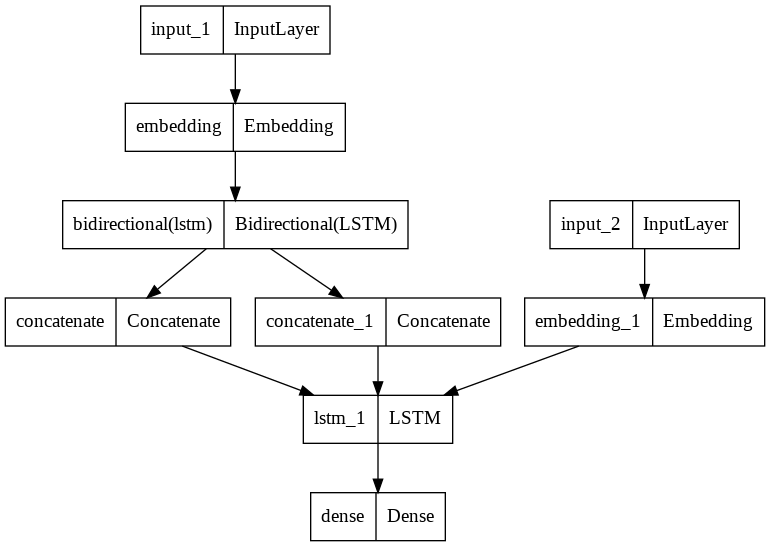

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [33]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
EPOCHS= 100

### Prepare input for encoder decoder model

In [35]:
# Training
encoder_input_data = X_train
decoder_input_data = y_train[:,:-1]
decoder_target_data = y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test= y_test[:,1:]

In [36]:
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data, 
                    epochs=EPOCHS, 
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test ))

Epoch 1/100
87/87 [==============================] - 50s 384ms/step - loss: 1.0919 - accuracy: 0.2818 - val_loss: 0.9765 - val_accuracy: 0.3333
Epoch 2/100
87/87 [==============================] - 29s 333ms/step - loss: 0.9036 - accuracy: 0.3447 - val_loss: 0.9391 - val_accuracy: 0.3592
Epoch 3/100
87/87 [==============================] - 29s 332ms/step - loss: 0.8140 - accuracy: 0.3715 - val_loss: 0.9010 - val_accuracy: 0.3765
Epoch 4/100
87/87 [==============================] - 29s 332ms/step - loss: 0.7182 - accuracy: 0.4012 - val_loss: 0.8696 - val_accuracy: 0.4054
Epoch 5/100
87/87 [==============================] - 29s 331ms/step - loss: 0.6115 - accuracy: 0.4391 - val_loss: 0.8470 - val_accuracy: 0.4254
Epoch 6/100
87/87 [==============================] - 29s 332ms/step - loss: 0.4971 - accuracy: 0.4870 - val_loss: 0.8370 - val_accuracy: 0.4389
Epoch 7/100
87/87 [==============================] - 29s 333ms/step - loss: 0.3842 - accuracy: 0.5600 - val_loss: 0.8332 - val_accuracy:

In [37]:
model.save("/content/gdrive/My Drive/colab_files/ara/modellstm4.h5")

### Inference Model

In [38]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import Input, Model

In [39]:
encoder_model = Model(encoder_input, encoder_states)

In [40]:
decoder_state_input_h = Input(shape=(1024,))
decoder_state_input_c= Input(shape=(1024,))
decoder_states_input= [decoder_state_input_h, decoder_state_input_c]

dec_embd2 = decoder_embd(decoder_input)

decoder_output2,state_h2, state_c2 = decoder_lstm(dec_embd2, initial_state=decoder_states_input)
deccoder_states2= [state_h2, state_c2]

decoder_output2 = decoder_dense(decoder_output2)

decoder_model = Model(
                      [decoder_input]+decoder_states_input,
                      [decoder_output2]+ deccoder_states2)

## Converting predicted numbers into text

In [41]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = ara_word_index['sos']
    
    # Sampling loop for a batch of sequences

    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index==0:
          break
        else:   
         # convert max index number to arabic word
         sampled_char = ara_index_word[sampled_token_index]
        # aapend it ti decoded sent
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence) >= 37):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    
    return decoded_sentence

In [42]:
def get_arabic_sentence(sequence):
  sentence=""
  for i in sequence:
    if ((i != 0 and i != ara_word_index['sos']) and i != ara_word_index['eos']):
      sentence = sentence + ara_index_word[i]+' '
  return sentence

def get_eng_sent(sequence):
    sentence =''
    for i in sequence:
      if(i!=0):
        sentence = sentence + eng_index_word[i]+' '
    return sentence       

In [43]:
for i in range(20):
  print("English sentence:",get_eng_sent(X_test[i]))
  print("Actual Arabic Sentence:",get_arabic_sentence(y_test[i]))
  print("Translated Arabic Sentence:",get_predicted_sentence(X_test[i].reshape(1,37))[:-4])
  print("\n")

English sentence: where will we meet 
Actual Arabic Sentence: أين سنلتقي؟ 
Translated Arabic Sentence:  أين سنأكل؟


English sentence: i tried to tell tom 
Actual Arabic Sentence: حاولت إخبار توم 
Translated Arabic Sentence:  حاولت أن توم


English sentence: he was foolish enough to believe what she said 
Actual Arabic Sentence: لقد كان أحمق بما يكفي ليصدق ما قالته 
Translated Arabic Sentence:  لقد كان غبي بما يكفي لتصديق ما ق


English sentence: i will give you a good piece of advice 
Actual Arabic Sentence: سأنصحك نصيحة مفيدة 
Translated Arabic Sentence:  سأشتري ساعةً لابني


English sentence: it will be easy to find someone to do that for you 
Actual Arabic Sentence: سيكون من السهل إيجاد شخص يقوم بذلك من أجلك 
Translated Arabic Sentence:  من الأفضل أن يكون الناس طريقة أفضل 


English sentence: where is the boss 
Actual Arabic Sentence: أين الرئيس؟ 
Translated Arabic Sentence:  أين الزعيم؟


English sentence: a prolonged silence followed 
Actual Arabic Sentence: حدث بعده سكون طويل 
T